<h1>Datetime recognizer</h1>
Train a model to recognize any datetimes in a given text string. 

Start with simple iso8601s and then progress to locales, timezones, countries & conventions.


Starting from the Keras autoencoder example.

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'
os.environ['CUDA_HOME'] = '/usr/local/cuda'

In [2]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning to decode localized datetimes from strings
Input: "Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"
or
       "Monday, 24 October 1977 at 09:10:55 Greenwich Mean Time"
Output: "2007-12-31T07:07:07.00000+02:00"
Padding is handled by using a repeated sentinel character (space)


Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

'''
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Dropout, Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
#from keras.callbacks import ReduceLROnPlateau
import numpy as np
from six.moves import range
import pytz
from datetime import datetime, timezone
import itertools
import random
from babel import Locale, localedata, UnknownLocaleError
from babel.dates import format_datetime
from tqdm import tqdm
import sys
import string
import math

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import math

In [4]:
%matplotlib inline

In [5]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, country_codes, maxlen):
        self.chars = set(string.ascii_letters + 
                         string.punctuation + 
                         string.digits
                        )

        ts_from = int(datetime(1980, 1, 1, tzinfo=timezone.utc).timestamp())
        ts_to   = int(datetime(1981, 1, 1, tzinfo=timezone.utc).timestamp())
        tstamps = [t for t in range(ts_from, ts_to, 60*1000)]
        retries = 0
        
        #Hoover up all the non-ascii characters that might be needed
        for country_code in tqdm(country_codes):
            try:                            
                if pytz.country_timezones.get(country_code):
                    for ctzone in pytz.country_timezones(country_code):
                        tzone = pytz.timezone(ctzone)
                        country_locale = Locale.parse('und_' + country_code)
                        for fmt  in ['short','medium','long','full']:
                            ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=tzone) for t in tstamps]
                            if random.choice([True, False]):
                                X = [format_datetime(dt, format=fmt, locale=country_locale) for dt in ydts]
                            else:
                                sep = random.choice([' ','T'])
                                X = [dt.isoformat(sep) for dt in ydts]

                            # So that's a years worth of datetimes for all the countrys & locales & timezones 
                            for ln in X:
                                # Going with case sensitive because some dt formats have an "i"
                                self.chars = self.chars.union( set(iter(ln)))
                                
            except UnknownLocaleError:
                print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
                retries += 1
                if retries >=21:
                    raise # Somethings gone wrong!

        self.chars = sorted(self.chars)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, sentence, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        chunk_size = len(self.chars)
        X = np.zeros((maxlen, chunk_size))
        for idx, c in enumerate(sentence[:maxlen]):
            X[idx, self.char_indices[c]] = 1
        return X

    def decode(self, X, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        ret = []
        chunk_size = len(self.chars)
        for idx in range(maxlen):
            retidx = X[idx,:].argmax(axis=-1)
            ret.append(self.indices_char[retidx])
        return ''.join(ret)


In [6]:
TESTSTRING = 'Monday 21st 1998-01-11 +GMT'
ctable = CharacterTable(['GB',], len("Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"))
xxx = ctable.encode(TESTSTRING)
yyy = ctable.decode(xxx)
print('Encoded.shape: %s' % str(xxx.shape))
print('Decoded: %s' % yyy)
assert(yyy.strip() == TESTSTRING)


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

Encoded.shape: (58, 95)
Decoded: Monday 21st 1998-01-11 +GMT                               


In [7]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [8]:
def DateTimeDataGenerator(sample_size):   
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = [random.randrange(0xFFFFFFFF) for _ in range(sample_size)]

        yield tstamps


In [9]:
def DateTimeFormattedGenerator(country_codes, sample_size, maxlen_x, maxlen_y):
    dtdg = DateTimeDataGenerator(sample_size)
    all_locales = localedata.locale_identifiers()
    limit          = 8
    locale_choices = []
    retries        = 0
    
    # Gather country and timezone options
    for country_code in country_codes:
        try:                            
            if pytz.country_timezones.get(country_code):
                for ctzone in pytz.country_timezones(country_code):
                    tzone = pytz.timezone(ctzone)
                    country_locale = Locale.parse('und_' + country_code)
                    for fmt  in ['short','medium','long','full']:
                        locale_choices.append({'country_code': country_code,
                                               'timezone'    : tzone,
                                               'format'      : fmt,
                                               'locale'      : country_locale
                                              })
        except UnknownLocaleError:
            print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
            retries += 1
            if retries >= 21:
                raise
    
    locale_choices = (locale_choices * math.ceil(sample_size/len(locale_choices)))[:sample_size]
    random.shuffle(locale_choices)
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)
        
        ydts  = [ datetime.utcfromtimestamp(t).replace(tzinfo=locale_choices[idx]['timezone']).isoformat('T') 
                  for idx, t in enumerate(tstamps)]        
        X = [format_datetime(datetime.utcfromtimestamp(t).replace(
                     tzinfo=locale_choices[idx]['timezone']), 
                     format=locale_choices[idx]['format'], 
                     locale=locale_choices[idx]['locale']
                     ) 
             for idx, t in enumerate(tstamps)]

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
            
        yield (X, ydts)

In [10]:
MAXLEN_X = 72 # longer than anything expected like 'Monday 31 December 2000 07:07:07.0000000 +02:00 CET/Europe'
MAXLEN_Y = len(datetime.now().isoformat(' '))

def DateTimeVectorGenerator(dt_generator, ctable, invert):    
    """
    Returns: x_batch [batch_size, n_timesteps, vocab_size] 
             y_batch [batch_size, n_categories]
    """
    X_next, y_next = next(dt_generator)
    while True:
        # X_next are all the same MAXLEN_X length. Same for y_next
        X = np.zeros((len(X_next), MAXLEN_X, len(ctable.chars)), dtype=np.bool)
        y = np.zeros((len(y_next), MAXLEN_Y, len(ctable.chars)), dtype=np.bool)
        
        for idx, sentence in enumerate(X_next):
            X[idx] = np.flipud(ctable.encode(sentence, MAXLEN_X)) if invert else ctable.encode(sentence, MAXLEN_X)
            
        for idx, sentence in enumerate(y_next):
            y[idx] = ctable.encode(sentence, MAXLEN_Y)
    
        yield X, y

In [11]:
def visualize_history(learning_hist, data_filename=None):    
    plt.figure(figsize=(12, 6))
    discard = int(math.ceil(len(learning_hist)/100))*20
    # skip the first few, they destroy plot scale
    plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
    plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

    plt.ylabel('error')
    plt.xlabel('iteration')
    plt.legend()
    #plt.ylim([0, 0.005])
    plt.title('training error')
    if (data_filename is not None):
        plt.savefig(data_filename)
        plt.close()
    else:
        plt.show()

In [12]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.003 #0.0016875 #0.000533935546875 #0.003
    drop = 0.80 #0.75
    epochs_drop = 15.0        
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))    
    
    if not epoch % epochs_drop:
        print('Learning rate adjusted: {}'.format(lrate), file=sys.stderr)
    
    return lrate

In [13]:
# Parameters for the model and dataset
TRAINING_SIZE   = 2345 #tuned to avoid ResourceExhaustedError: OOM when allocating tensor with shape
VALIDATION_SIZE = 234
INVERT = True
# Try replacing GRU, LSTM or SimpleRNN
RNN = recurrent.GRU
BATCH_SIZE = 128
LAYERS = 3

COUNTRY_CODES = ['GB', ] #'US', 'IE', 'AU','DE','FR','ES','IT','CA', 'NO','SE','DK','FI','EE','CZ','PL'] # pytz.country_names.keys()
EPOCHS=106
HIDDEN_SIZE = math.ceil(MAXLEN_X * 1.5) # GRU #9 - SimpleRNN to 80%acc




In [14]:
ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)

100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


In [15]:
#gen_dt = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt, ctable, INVERT)

X_train, y_train = next(gen_vec_train)
print('X_train.shape: %s'%str(X_train.shape))
print('y_train.shape: %s'%str(y_train.shape))

X_train.shape: (2345, 72, 95)
y_train.shape: (2345, 26, 95)


In [16]:
#gen_dt_test = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_test = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_test = DateTimeVectorGenerator(gen_dt_test, ctable, INVERT)

X_test, y_test = next(gen_vec_test)
print('X_test.shape:%s \ny_test.shape: %s' % (str(X_test.shape), str(y_test.shape)))

X_test.shape:(2345, 72, 95) 
y_test.shape: (2345, 26, 95)


In [17]:
stopper = EarlyStopping(patience=25, 
                        verbose=1, 
                        mode='auto')

In [18]:
checkpointer = ModelCheckpoint('../models/checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

In [19]:
learning_hist = []

In [20]:
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate, ]

In [21]:
print('Build model...')
model = Sequential()


# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=MAXLEN_X,
                        filter_length=3,   # len('yyyy') # len('/mm')
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1, input_shape=(ctable.maxlen, len(ctable.chars))))
model.add(Flatten())
#model.add(RNN(HIDDEN_SIZE, return_sequences=False))
model.add(Dropout(0.2))

# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(MAXLEN_Y))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, 
                  activation='relu',
                  return_sequences=True)
             )

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(ctable.chars), 
                                activation='softmax')
                         ))


opt = RMSprop(lr=0) # Using LR scheduler

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 70, 72)        20592       convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 5040)          0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 5040)          0           flatten_1[0][0]                  
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 26, 5040)      0           dropout_1[0][0]                  
____________________________________________________________________________

Learning rate adjusted: 0.003


Epoch 1/106
63315/63315 [==============================] - 58s - loss: 2.8486 - acc: 0.2154 - val_loss: 2.2808 - val_acc: 0.2423
Epoch 2/106
63315/63315 [==============================] - 27s - loss: 2.2402 - acc: 0.2661 - val_loss: 2.1896 - val_acc: 0.2623
Epoch 3/106
63315/63315 [==============================] - 27s - loss: 2.1258 - acc: 0.2859 - val_loss: 1.9167 - val_acc: 0.3927
Epoch 4/106
63315/63315 [==============================] - 27s - loss: 1.9461 - acc: 0.3503 - val_loss: 2.0262 - val_acc: 0.2801
Epoch 5/106
63315/63315 [==============================] - 27s - loss: 1.7638 - acc: 0.3943 - val_loss: 1.5637 - val_acc: 0.4328
Epoch 6/106
63315/63315 [==============================] - 27s - loss: 1.6338 - acc: 0.4298 - val_loss: 1.5159 - val_acc: 0.4504
Epoch 7/106
63315/63315 [==============================] - 27s - loss: 1.4717 - acc: 0.4630 - val_loss: 1.3023 - val_acc: 0.5061
Epoch 8/106
63315/63315 [==============================] - 27s - loss: 1.3470 - acc: 0.4992 - val

Learning rate adjusted: 0.0024000000000000002


63315/63315 [==============================] - 27s - loss: 0.6480 - acc: 0.7521 - val_loss: 0.6730 - val_acc: 0.7424
Epoch 17/106
63315/63315 [==============================] - 27s - loss: 0.6136 - acc: 0.7695 - val_loss: 0.8111 - val_acc: 0.7181
Epoch 18/106
63315/63315 [==============================] - 27s - loss: 0.6383 - acc: 0.7736 - val_loss: 0.6382 - val_acc: 0.7625
Epoch 19/106
63315/63315 [==============================] - 27s - loss: 0.5446 - acc: 0.7974 - val_loss: 0.6042 - val_acc: 0.7812
Epoch 20/106
63315/63315 [==============================] - 27s - loss: 0.5255 - acc: 0.8053 - val_loss: 0.6067 - val_acc: 0.7799
Epoch 21/106
63315/63315 [==============================] - 27s - loss: 0.4843 - acc: 0.8210 - val_loss: 0.5785 - val_acc: 0.7885
Epoch 22/106
63315/63315 [==============================] - 27s - loss: 0.4624 - acc: 0.8307 - val_loss: 2.7299 - val_acc: 0.5980
Epoch 23/106
63315/63315 [==============================] - 27s - loss: 0.5288 - acc: 0.8363 - val_loss

Learning rate adjusted: 0.0019200000000000005


63315/63315 [==============================] - 27s - loss: 0.2097 - acc: 0.9250 - val_loss: 0.5981 - val_acc: 0.8276
Epoch 32/106
63315/63315 [==============================] - 27s - loss: 0.1964 - acc: 0.9309 - val_loss: 0.5846 - val_acc: 0.8317
Epoch 33/106
63315/63315 [==============================] - 27s - loss: 0.1745 - acc: 0.9401 - val_loss: 0.5653 - val_acc: 0.8416
Epoch 34/106
63315/63315 [==============================] - 27s - loss: 0.1593 - acc: 0.9449 - val_loss: 0.6679 - val_acc: 0.8177
Epoch 35/106
63315/63315 [==============================] - 27s - loss: 0.1463 - acc: 0.9497 - val_loss: 0.6947 - val_acc: 0.8194
Epoch 36/106
63315/63315 [==============================] - 27s - loss: 0.1293 - acc: 0.9562 - val_loss: 0.6423 - val_acc: 0.8397
Epoch 37/106
63315/63315 [==============================] - 27s - loss: 0.1277 - acc: 0.9573 - val_loss: 0.6264 - val_acc: 0.8491
Epoch 38/106
63315/63315 [==============================] - 27s - loss: 0.1054 - acc: 0.9658 - val_loss

Learning rate adjusted: 0.0015360000000000005


63315/63315 [==============================] - 27s - loss: 0.0357 - acc: 0.9902 - val_loss: 0.7969 - val_acc: 0.8516
Epoch 47/106
63315/63315 [==============================] - 27s - loss: 0.0371 - acc: 0.9902 - val_loss: 1.0200 - val_acc: 0.8225
Epoch 48/106
63315/63315 [==============================] - 27s - loss: 0.0537 - acc: 0.9856 - val_loss: 0.8084 - val_acc: 0.8409
Epoch 49/106
63315/63315 [==============================] - 27s - loss: 0.0385 - acc: 0.9901 - val_loss: 0.7380 - val_acc: 0.8542
Epoch 50/106
63315/63315 [==============================] - 27s - loss: 0.0357 - acc: 0.9915 - val_loss: 0.7660 - val_acc: 0.8547
Epoch 51/106
63315/63315 [==============================] - 27s - loss: 0.0330 - acc: 0.9917 - val_loss: 0.7647 - val_acc: 0.8517
Epoch 52/106
63315/63315 [==============================] - 27s - loss: 0.0379 - acc: 0.9907 - val_loss: 0.7569 - val_acc: 0.8531
Epoch 53/106
63315/63315 [==============================] - 27s - loss: 0.0093 - acc: 0.9983 - val_loss

Learning rate adjusted: 0.0012288000000000002


63315/63315 [==============================] - 27s - loss: 0.0236 - acc: 0.9944 - val_loss: 0.9036 - val_acc: 0.8550
Epoch 62/106
63315/63315 [==============================] - 27s - loss: 0.0197 - acc: 0.9951 - val_loss: 0.8518 - val_acc: 0.8534
Epoch 63/106
63315/63315 [==============================] - 27s - loss: 0.0039 - acc: 0.9994 - val_loss: 0.9493 - val_acc: 0.8570
Epoch 64/106
63315/63315 [==============================] - 27s - loss: 0.0207 - acc: 0.9949 - val_loss: 0.9062 - val_acc: 0.8572
Epoch 65/106
63315/63315 [==============================] - 27s - loss: 0.0212 - acc: 0.9954 - val_loss: 0.8693 - val_acc: 0.8499
Epoch 66/106
63315/63315 [==============================] - 27s - loss: 0.0039 - acc: 0.9993 - val_loss: 0.9550 - val_acc: 0.8568
Epoch 67/106
63315/63315 [==============================] - 27s - loss: 0.0228 - acc: 0.9945 - val_loss: 0.9145 - val_acc: 0.8552
Epoch 68/106
63315/63315 [==============================] - 27s - loss: 0.0024 - acc: 0.9996 - val_loss

Learning rate adjusted: 0.0009830400000000003


63315/63315 [==============================] - 27s - loss: 0.0088 - acc: 0.9980 - val_loss: 1.0043 - val_acc: 0.8595
Epoch 77/106
63315/63315 [==============================] - 27s - loss: 0.0087 - acc: 0.9979 - val_loss: 0.9926 - val_acc: 0.8570
Epoch 78/106
63315/63315 [==============================] - 27s - loss: 0.0033 - acc: 0.9992 - val_loss: 1.2232 - val_acc: 0.8396
Epoch 79/106
63315/63315 [==============================] - 27s - loss: 0.0068 - acc: 0.9986 - val_loss: 1.0334 - val_acc: 0.8586
Epoch 80/106
63315/63315 [==============================] - 27s - loss: 0.0097 - acc: 0.9974 - val_loss: 0.9671 - val_acc: 0.8570
Epoch 81/106
63315/63315 [==============================] - 27s - loss: 0.0013 - acc: 0.9998 - val_loss: 1.0329 - val_acc: 0.8600
Epoch 82/106
63315/63315 [==============================] - 27s - loss: 0.0087 - acc: 0.9978 - val_loss: 0.9923 - val_acc: 0.8586
Epoch 83/106
63315/63315 [==============================] - 27s - loss: 0.0012 - acc: 0.9998 - val_loss

Learning rate adjusted: 0.0007864320000000003


63315/63315 [==============================] - 27s - loss: 0.0021 - acc: 0.9994 - val_loss: 1.0622 - val_acc: 0.8600
Epoch 92/106
63315/63315 [==============================] - 27s - loss: 9.4935e-04 - acc: 0.9998 - val_loss: 1.0837 - val_acc: 0.8588
Epoch 93/106
63315/63315 [==============================] - 27s - loss: 0.0034 - acc: 0.9991 - val_loss: 1.0721 - val_acc: 0.8572
Epoch 94/106
63315/63315 [==============================] - 27s - loss: 9.3663e-04 - acc: 0.9998 - val_loss: 1.1167 - val_acc: 0.8560
Epoch 95/106
63315/63315 [==============================] - 27s - loss: 0.0042 - acc: 0.9989 - val_loss: 1.0914 - val_acc: 0.8572
Epoch 96/106
63315/63315 [==============================] - 27s - loss: 7.6630e-04 - acc: 0.9999 - val_loss: 1.1191 - val_acc: 0.8568
Epoch 97/106
63315/63315 [==============================] - 27s - loss: 0.0032 - acc: 0.9991 - val_loss: 1.1015 - val_acc: 0.8559
Epoch 98/106
63315/63315 [==============================] - 27s - loss: 7.7545e-04 - acc: 0

Learning rate adjusted: 0.0006291456000000002


63315/63315 [==============================] - 27s - loss: 6.8172e-04 - acc: 0.9998 - val_loss: 1.1435 - val_acc: 0.8603
Q Wednesday, 13 December 2090 at 10:29:06 Greenwich Mean Time             
T 2090-12-13T10:29:06-00:01 
☒ 2036-12-10T00:21:09-00:01 
Q 1 June 2096 at 04:13:52 GMT                                             
T 2096-06-01T04:13:52-00:01 
☒ 2092-06-03T03:34:52-00:01 
Q 3 Dec 2092, 05:36:32                                                    
T 2092-12-03T05:36:32-00:01 
☒ 2092-12-01T05:36:21-00:01 
Q Saturday, 29 October 2061 at 14:12:28 Greenwich Mean Time               
T 2061-10-29T14:12:28-00:01 
☒ 2041-10-29T03:58:28-00:01 
Q 4 September 2071 at 19:07:12 GMT                                        
T 2071-09-04T19:07:12-00:01 
☒ 2071-09-02T19:16:12-00:01 


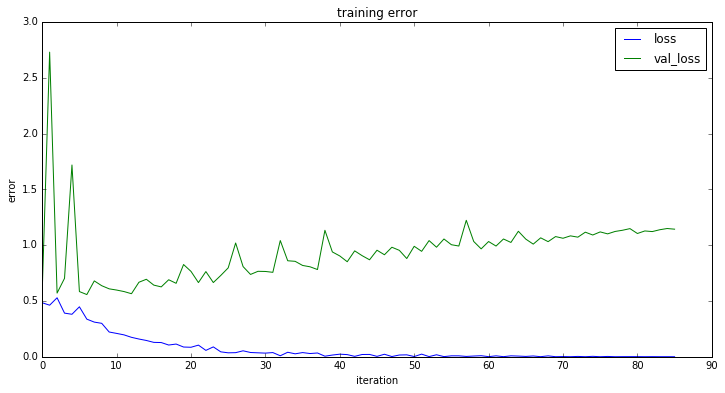

In [22]:
# Train the model each generation and show predictions against the validation dataset

gen_dt_train = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y)
gen_dt_val   = DateTimeFormattedGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y)

gen_vec_train      = DateTimeVectorGenerator(gen_dt_train, ctable, INVERT)
gen_vec_validation = DateTimeVectorGenerator(gen_dt_val,   ctable, INVERT)

learning_hist.append(
        model.fit_generator( gen_vec_train, 
                            samples_per_epoch = 27 * TRAINING_SIZE,
                            nb_epoch=EPOCHS, 
                            verbose=1, 
                            callbacks=callbacks_list, 
                            validation_data=gen_vec_validation, 
                            nb_val_samples=VALIDATION_SIZE, 
                            #class_weight={}, 
                            #max_q_size=10, 
                            #nb_worker=1, 
                            #pickle_safe=False
                           )
        )

model.save('../models/datatime_autoencoder_model_mkIV.h5')

for idx in range(5):
    X_test, y_test = next(gen_vec_test)            
    preds = model.predict(X_test, verbose=0)
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

visualize_history(learning_hist)            

In [23]:
X_train.shape

(2345, 72, 95)

<h1>Results</h1>

~~~
Learning rate adjusted: 0.0007864320000000003
63315/63315 [==============================] - 27s - loss: 0.0021 - acc: 0.9994 - val_loss: 1.0622 - val_acc: 0.8600
Epoch 92/106
63315/63315 [==============================] - 27s - loss: 9.4935e-04 - acc: 0.9998 - val_loss: 1.0837 - val_acc: 0.8588
Epoch 93/106
63315/63315 [==============================] - 27s - loss: 0.0034 - acc: 0.9991 - val_loss: 1.0721 - val_acc: 0.8572
Epoch 94/106
63315/63315 [==============================] - 27s - loss: 9.3663e-04 - acc: 0.9998 - val_loss: 1.1167 - val_acc: 0.8560
Epoch 95/106
63315/63315 [==============================] - 27s - loss: 0.0042 - acc: 0.9989 - val_loss: 1.0914 - val_acc: 0.8572
Epoch 96/106
63315/63315 [==============================] - 27s - loss: 7.6630e-04 - acc: 0.9999 - val_loss: 1.1191 - val_acc: 0.8568
Epoch 97/106
63315/63315 [==============================] - 27s - loss: 0.0032 - acc: 0.9991 - val_loss: 1.1015 - val_acc: 0.8559
Epoch 98/106
63315/63315 [==============================] - 27s - loss: 7.7545e-04 - acc: 0.9998 - val_loss: 1.1231 - val_acc: 0.8542
Epoch 99/106
63315/63315 [==============================] - 27s - loss: 0.0013 - acc: 0.9997 - val_loss: 1.1339 - val_acc: 0.8555
Epoch 100/106
63315/63315 [==============================] - 27s - loss: 0.0014 - acc: 0.9997 - val_loss: 1.1485 - val_acc: 0.8572
Epoch 101/106
63315/63315 [==============================] - 27s - loss: 0.0015 - acc: 0.9996 - val_loss: 1.1049 - val_acc: 0.8573
Epoch 102/106
63315/63315 [==============================] - 27s - loss: 8.5267e-04 - acc: 0.9998 - val_loss: 1.1277 - val_acc: 0.8567
Epoch 103/106
63315/63315 [==============================] - 27s - loss: 0.0014 - acc: 0.9996 - val_loss: 1.1220 - val_acc: 0.8573
Epoch 104/106
63315/63315 [==============================] - 27s - loss: 9.1089e-04 - acc: 0.9998 - val_loss: 1.1385 - val_acc: 0.8583
Epoch 105/106
63315/63315 [==============================] - 27s - loss: 9.0268e-04 - acc: 0.9998 - val_loss: 1.1495 - val_acc: 0.8565
Epoch 106/106
Learning rate adjusted: 0.0006291456000000002
63315/63315 [==============================] - 27s - loss: 6.8172e-04 - acc: 0.9998 - val_loss: 1.1435 - val_acc: 0.8603
Q Wednesday, 13 December 2090 at 10:29:06 Greenwich Mean Time             
T 2090-12-13T10:29:06-00:01 
☒ 2036-12-10T00:21:09-00:01 
Q 1 June 2096 at 04:13:52 GMT                                             
T 2096-06-01T04:13:52-00:01 
☒ 2092-06-03T03:34:52-00:01 
Q 3 Dec 2092, 05:36:32                                                    
T 2092-12-03T05:36:32-00:01 
☒ 2092-12-01T05:36:21-00:01 
Q Saturday, 29 October 2061 at 14:12:28 Greenwich Mean Time               
T 2061-10-29T14:12:28-00:01 
☒ 2041-10-29T03:58:28-00:01 
Q 4 September 2071 at 19:07:12 GMT                                        
T 2071-09-04T19:07:12-00:01 
☒ 2071-09-02T19:16:12-00:01  
~~~

In [24]:
X_test, y_test = next(gen_vec_validation)            
preds = model.predict(X_test, verbose=0)
for idx in range(10):
    i = random.randrange(len(preds))    
    q = ctable.decode(X_test[i], MAXLEN_X)    
    correct = ctable.decode(y_test[i], MAXLEN_Y)
    guess = ctable.decode(preds[i], MAXLEN_Y)
    print('Q', q[::-1] if INVERT else q )
    print('T', correct)
    print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

Q 25/09/2032, 22:48                                                       
T 2032-09-25T22:48:52-00:01 
☒ 2022-09-25T22:48:12-00:01 
Q 15/01/2034, 20:47                                                       
T 2034-01-15T20:47:11-00:01 
☒ 2034-01-15T23:47:08-00:01 
Q 16 March 2100 at 13:56:32 GMT                                           
T 2100-03-16T13:56:32-00:01 
☒ 2101-03-16T12:36:41-00:01 
Q 8 May 1972, 09:10:27                                                    
T 1972-05-08T09:10:27-00:01 
☒ 1972-05-08T19:10:20-00:01 
Q 8 Sep 2000, 00:53:29                                                    
T 2000-09-08T00:53:29-00:01 
☒ 2000-09-08T00:53:28-00:01 
Q 26/02/2084, 07:14                                                       
T 2084-02-26T07:14:19-00:01 
☒ 2084-02-26T07:14:39-00:01 
Q 23/11/2074, 10:48                                                       
T 2074-11-23T10:48:12-00:01 
☒ 2074-11-23T10:48:29-00:01 
Q 7 Dec 2002, 23:28:47                                               

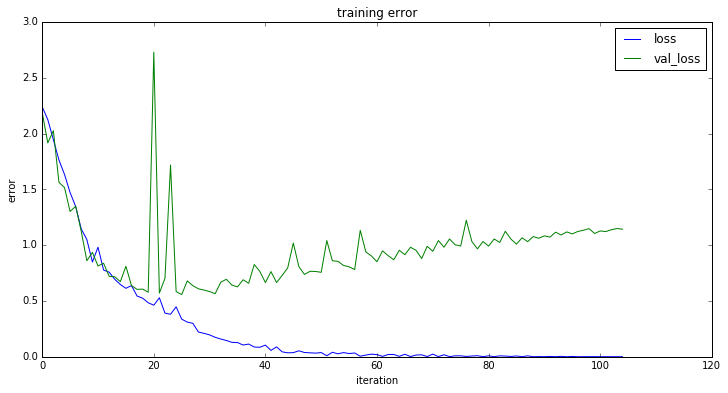

In [34]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['loss'][discard:]], label='loss')
plt.plot([i for i in learning_hist[-1].history['val_loss'][discard:]], label='val_loss')

plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training error')
plt.show()

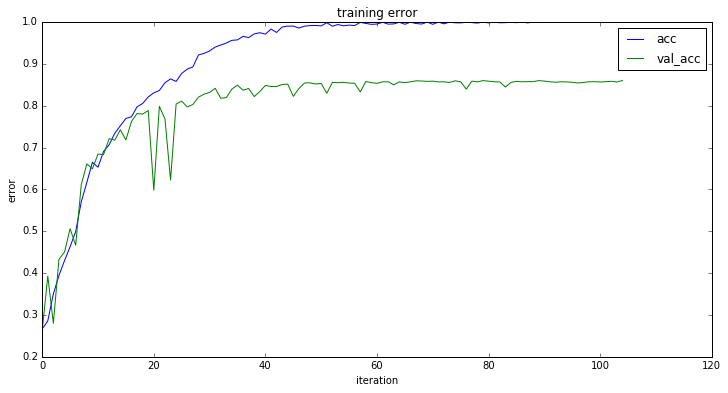

In [33]:
plt.figure(figsize=(12, 6))
discard = int(math.ceil(len(learning_hist)/100))*1
# skip the first few, they destroy plot scale
plt.plot([i for i in learning_hist[-1].history['acc'][discard:]], label='acc')
plt.plot([i for i in learning_hist[-1].history['val_acc'][discard:]], label='val_acc')

plt.ylabel('error')
plt.xlabel('iteration')
plt.legend()
#plt.ylim([0, 0.005])
plt.title('training error')
plt.show()

In [29]:
#len(learning_hist[0].history['loss'])

In [30]:
#model.save('../models/datatime_autoencoder_model.h5')

In [31]:
next(gen_dt)

(['18/03/2055, 23:25                                                       ',
  '28/08/2026, 10:19                                                       ',
  '24 December 2035 at 19:55:55 GMT                                        ',
  '03/06/1997, 14:03                                                       ',
  '14 October 2102 at 14:38:46 GMT                                         ',
  'Wednesday, 5 September 2091 at 17:58:30 Greenwich Mean Time             ',
  '2 Feb 2012, 05:11:49                                                    ',
  'Wednesday, 29 May 1985 at 01:42:27 Greenwich Mean Time                  ',
  '27 April 2066 at 03:28:17 GMT                                           ',
  '14 Jun 2040, 17:59:03                                                   ',
  '25 Sep 2036, 05:19:13                                                   ',
  '28 Feb 2012, 07:02:52                                                   ',
  'Thursday, 5 September 2086 at 06:05:45 Greenwich Mean Time   

In [32]:
model.load_weights('../models/datatime_autoencoder_model_mkIV.h5')